In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm_notebook as tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
import DynamicCoop as dc  # Import the main module

# Set up plotting style
%matplotlib inline
sns.set_theme()


Note: you may need to restart the kernel to use updated packages.


In [31]:
# Set default widget style to increase width
style = {'description_width': '150px'}  # Increase label width
layout = widgets.Layout(width='500px')  # Increase total widget width

# Create widgets for parameter control
params = {
    # Trust and loyalty parameters
    'initial_trust': widgets.FloatSlider(
        value=0.5, min=0, max=1.0, step=0.1, 
        description='Initial Trust',
        style=style, layout=layout),
    'trust_increase': widgets.FloatSlider(
        value=0.1, min=0, max=0.5, step=0.05, 
        description='Trust Increase',
        style=style, layout=layout),
    'trust_decrease': widgets.FloatSlider(
        value=0.2, min=0, max=0.5, step=0.05, 
        description='Trust Decrease',
        style=style, layout=layout),
    'trust_threshold': widgets.FloatSlider(
        value=0.6, min=0, max=1.0, step=0.1, 
        description='Trust Threshold',
        style=style, layout=layout),
    
    # Fisher numbers
    'fully_noncoop': widgets.IntSlider(
        value=4, min=0, max=10, step=1, 
        description='Fully Non-cooperative',
        style=style, layout=layout),
    'noncoop': widgets.IntSlider(
        value=4, min=0, max=10, step=1, 
        description='Non-cooperative',
        style=style, layout=layout),
    'cond_coop': widgets.IntSlider(
        value=4, min=0, max=10, step=1, 
        description='Conditional Coop',
        style=style, layout=layout),
    'coop': widgets.IntSlider(
        value=4, min=0, max=10, step=1, 
        description='Cooperative',
        style=style, layout=layout),
    'fully_coop': widgets.IntSlider(
        value=4, min=0, max=10, step=1, 
        description='Fully Cooperative',
        style=style, layout=layout),
    
    # MPA parameters
    'MPA': widgets.Dropdown(
        options=['yes', 'no'], value='yes', 
        description='MPA Present',
        style=style, layout=layout),
    'Type_MPA': widgets.Dropdown(
        options=['single', 'spaced'], value='single', 
        description='MPA Type',
        style=style, layout=layout),
    'Frac_MPA': widgets.FloatSlider(
        value=0.25, min=0.1, max=0.5, step=0.05, 
        description='MPA Fraction',
        style=style, layout=layout),
    
    # Other parameters
    'K': widgets.IntSlider(
        value=200, min=100, max=500, step=50, 
        description='Carrying Capacity',
        style=style, layout=layout),
    'init_fish': widgets.IntSlider(
        value=200, min=100, max=500, step=50, 
        description='Initial Fish',
        style=style, layout=layout),
    'n_sims': widgets.IntSlider(
        value=10, min=5, max=100, step=5, 
        description='Number of Sims',
        style=style, layout=layout),
}

# Create layout with some padding between elements
trust_box = widgets.VBox([params['initial_trust'], params['trust_increase'], 
                         params['trust_decrease'], params['trust_threshold']], 
                         layout=widgets.Layout(padding='10px'))
fisher_box = widgets.VBox([params['fully_noncoop'], params['noncoop'], 
                          params['cond_coop'], params['coop'], params['fully_coop']],
                          layout=widgets.Layout(padding='10px'))
mpa_box = widgets.VBox([params['MPA'], params['Type_MPA'], params['Frac_MPA']],
                       layout=widgets.Layout(padding='10px'))
other_box = widgets.VBox([params['K'], params['init_fish'], params['n_sims']],
                         layout=widgets.Layout(padding='10px'))

# Create tabs with increased height to prevent scrolling
tab = widgets.Tab([trust_box, fisher_box, mpa_box, other_box],
                 layout=widgets.Layout(width='550px', height='400px'))
tab.set_title(0, 'Trust Parameters')
tab.set_title(1, 'Fisher Numbers')
tab.set_title(2, 'MPA Settings')
tab.set_title(3, 'Other Parameters')

display(tab)


In [35]:
def run_simulation(b):
    # Get parameter values from widgets
    # Trust parameters
    dc.initial_trust = trust_params.children[0].value
    dc.trust_increase = trust_params.children[1].value
    dc.trust_decrease = trust_params.children[2].value
    dc.trust_radius = trust_params.children[3].value
    dc.trust_memory = trust_params.children[4].value
    dc.trust_threshold = trust_params.children[5].value
    
    # Fisher numbers
    dc.fully_noncoop = fisher_numbers.children[0].value
    dc.noncoop = fisher_numbers.children[1].value
    dc.cond_coop = fisher_numbers.children[2].value
    dc.coop = fisher_numbers.children[3].value
    dc.fully_coop = fisher_numbers.children[4].value
    dc.num_fishers = sum([dc.fully_noncoop, dc.noncoop, dc.cond_coop, dc.coop, dc.fully_coop])
    
    # MPA settings
    dc.MPA = mpa_settings.children[0].value
    dc.Both = mpa_settings.children[1].value
    dc.Time_MPA = mpa_settings.children[2].value
    dc.Type_MPA = mpa_settings.children[3].value
    dc.Dist_MPA = mpa_settings.children[4].value
    dc.Frac_MPA = mpa_settings.children[5].value
    
    # Other parameters
    dc.K = other_params.children[0].value
    dc.n = other_params.children[1].value
    dc.base_growth_prob = other_params.children[2].value
    dc.init_fish = other_params.children[3].value
    dc.q = other_params.children[4].value
    
    # Run simulation
    dc.initialize()
    
    # Create progress bar
    progress = tqdm(range(1, dc.n), desc="Simulating")
    
    # Setup figure for live plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    plt.ion()
    
    # Run simulation with live plotting
    for step in progress:
        dc.update_one_unit_time()
        
        if step % 5 == 0:  # Update plot every 5 steps
            clear_output(wait=True)
            
            # Plot fish populations
            ax1.clear()
            ax1.plot(dc.fish_data, 'b-', label='Total fish')
            ax1.plot(dc.fish_data_MPA, 'g-', label='Fish in MPA')
            ax1.plot(dc.fishermen_data3, 'r-', label='Fish outside MPA')
            ax1.set_title('Fish Population Dynamics')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Number of fish')
            ax1.legend()
            ax1.grid(True)
            
            # Plot fishing activity
            ax2.clear()
            ax2.plot(dc.fishermen_data1, 'b-', label='Total catch')
            ax2.plot(dc.fishermen_data2, 'r-', label='Current catch')
            ax2.set_title('Fishing Activity')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Number of fish caught')
            ax2.legend()
            ax2.grid(True)
            
            plt.tight_layout()
            display(fig)
            
    plt.ioff()
    
    # Save final plots
    dc.plot_summary()
    dc.save_cooperation_data()
    dc.save_trust_data()

# Connect button to run function
run_button.on_click(run_simulation)


In [36]:
def update_dc_parameters():
    """Update DynamicCoop parameters with current widget values"""
    # Trust parameters
    dc.initial_trust = params['initial_trust'].value
    dc.trust_increase = params['trust_increase'].value
    dc.trust_decrease = params['trust_decrease'].value
    dc.trust_threshold = params['trust_threshold'].value
    
    # Fisher numbers
    dc.fully_noncoop = params['fully_noncoop'].value
    dc.noncoop = params['noncoop'].value
    dc.cond_coop = params['cond_coop'].value
    dc.coop = params['coop'].value
    dc.fully_coop = params['fully_coop'].value
    
    # Update total number of fishers
    dc.num_fishers = sum([dc.fully_noncoop, dc.noncoop, dc.cond_coop, 
                         dc.coop, dc.fully_coop])
    
    # MPA parameters
    dc.MPA = params['MPA'].value
    dc.Type_MPA = params['Type_MPA'].value
    dc.Frac_MPA = params['Frac_MPA'].value
    
    # Other parameters
    dc.K = params['K'].value
    dc.init_fish = params['init_fish'].value


Button(description='Run Simulation', style=ButtonStyle())

Starting simulation with current parameters:
Number of fishers: 50
MPA settings: yes, Type: single, Fraction: 0.25
Running 100 simulations...


/var/folders/q8/nf645rpd7xd2_wslc8zd02zw0000gn/T/ipykernel_20633/75045749.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_sims), desc="Running simulations"):


Running simulations:   0%|          | 0/100 [00:00<?, ?it/s]


Completed 100 simulations of 150 timesteps each
Total timesteps simulated: 15,000
Total time: 36.55 seconds


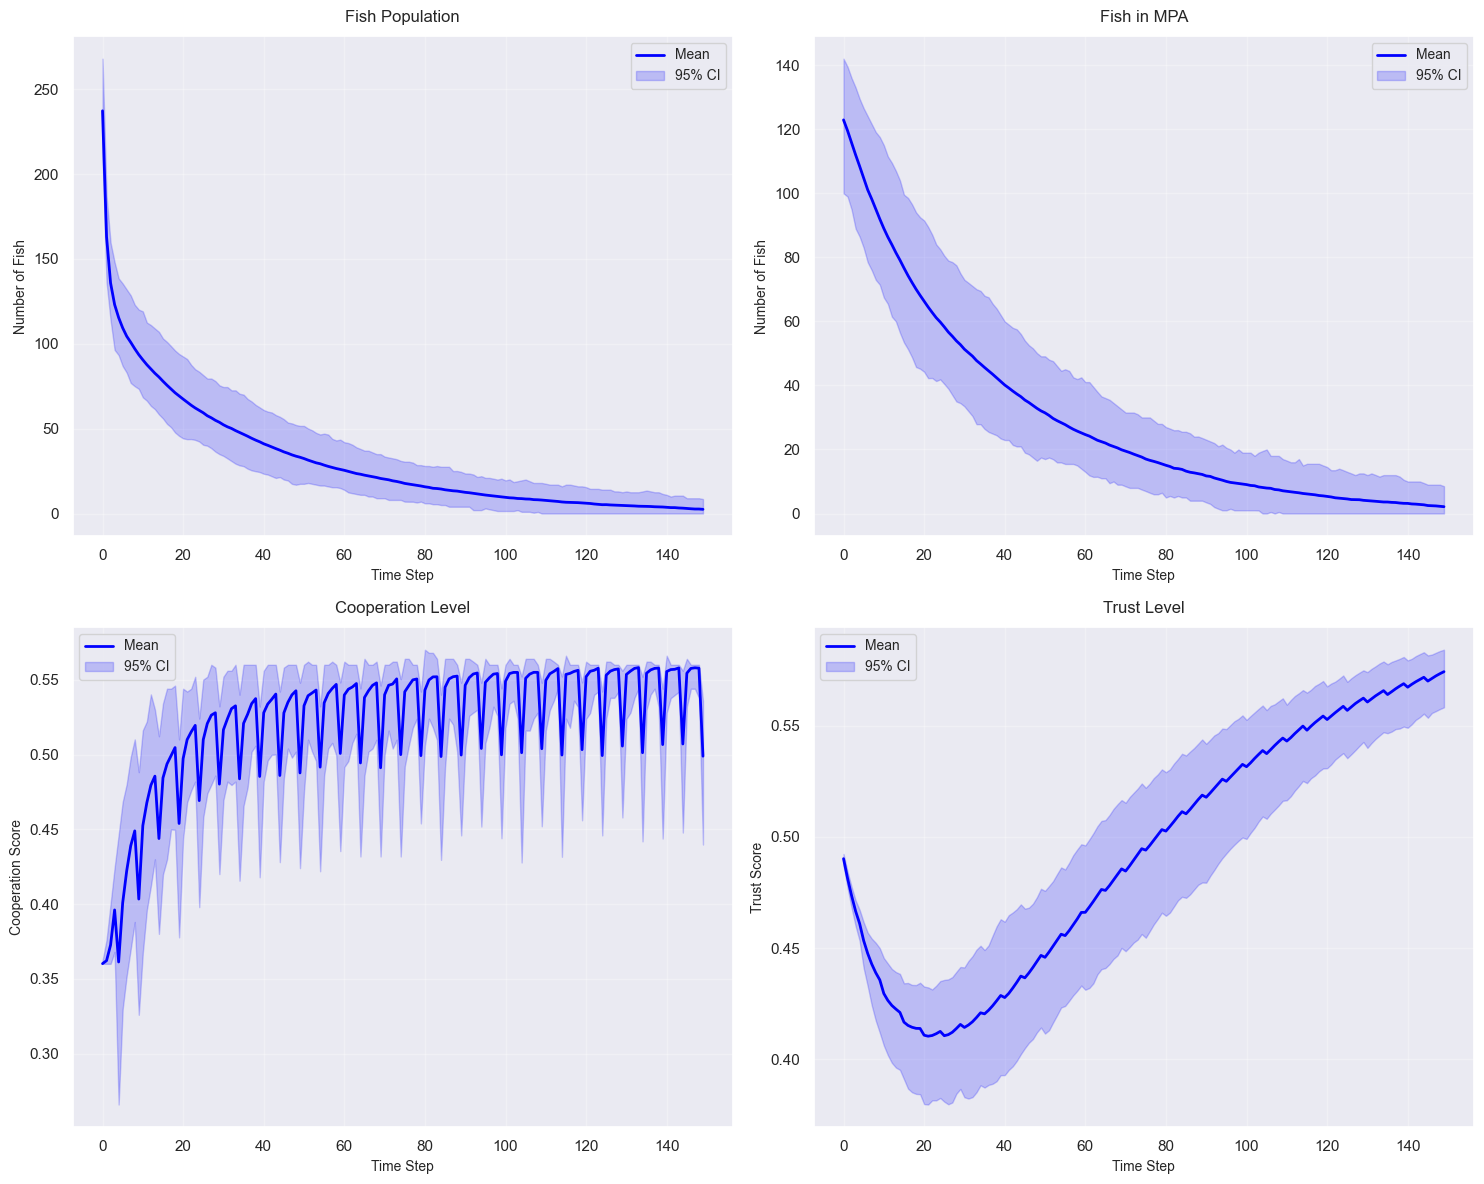

In [37]:
def run_simulation_with_params(b=None):
    """Run simulations with current parameter values"""
    # Update parameters
    update_dc_parameters()
    
    print("Starting simulation with current parameters:")
    print(f"Number of fishers: {dc.num_fishers}")
    print(f"MPA settings: {dc.MPA}, Type: {dc.Type_MPA}, Fraction: {dc.Frac_MPA}")
    print(f"Running {params['n_sims'].value} simulations...")
    
    # Run simulations
    start_time = time.time()
    results = run_multiple_simulations(n_sims=params['n_sims'].value)
    end_time = time.time()
    
    # Print timing info
    total_time = end_time - start_time
    print(f"\nCompleted {params['n_sims'].value} simulations of 150 timesteps each")
    print(f"Total timesteps simulated: {params['n_sims'].value * 150:,}")
    print(f"Total time: {total_time:.2f} seconds")
    
    # Create and display plot
    fig = plot_results_with_ci(results)
    plt.show()

# Create run button
run_button = widgets.Button(description='Run Simulation')
run_button.on_click(run_simulation_with_params)
display(run_button)
